In [33]:
import glob
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
from torchvision.transforms import ToPILImage, Resize
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [34]:
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    tensors = tensors.permute(1, 2, 0) * (std * 255) + (mean * 255)
    return torch.clamp(tensors, 0, 255).permute(2, 0, 1)



In [35]:
class SRDataset(Dataset):
    def __init__(self, pathlist, hr_shape) -> None:
        super().__init__()
        hr_height, hr_width = hr_shape
        self.hr_transform = A.Compose([
            A.RandomCrop(hr_height, hr_width),
            A.HorizontalFlip(),
            A.RandomRotate90(),
            A.Resize(hr_height, hr_width, interpolation=Image.BICUBIC),
            A.Normalize(),
        ])
        self.lr_transform = A.Resize(hr_height // 4, hr_width // 4, interpolation=Image.BICUBIC)
        self.final_transform = ToTensorV2()
        self.files = []
        for path in pathlist:
            self.files += glob.glob(path + "/*.*")
        self.hr_height, self.hr_width = hr_shape
    
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, index):
        img = cv2.imread(self.files[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_hr = self.hr_transform(image=img)['image']
        img_lr = self.lr_transform(image=img_hr)['image']
        img_hr, img_lr = self.final_transform(image=img_hr)['image'], self.final_transform(image=img_lr)['image']
        return {"lr": img_lr, "hr": img_hr}

In [36]:
pathlist = ["../datasets/DIV2K/DIV2K_train_HR"]
ds = SRDataset(pathlist, (256, 256))
dl = DataLoader(ds, batch_size=4)

/tmp/ipykernel_20977/3426011763.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  A.Resize(hr_height, hr_width, interpolation=Image.BICUBIC),
/tmp/ipykernel_20977/3426011763.py:12: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  self.lr_transform = A.Resize(hr_height // 4, hr_width // 4, interpolation=Image.BICUBIC)


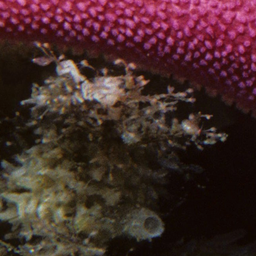

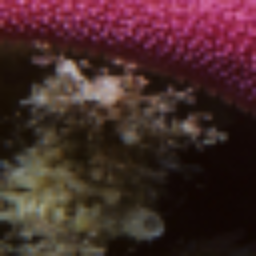

In [43]:
batch = next(iter(dl))
lr, hr = batch["lr"][0], batch["hr"][0]
log_lr = denormalize(lr).type(torch.uint8)
log_hr = denormalize(hr).type(torch.uint8)
log_lr = Resize((256, 256))(log_lr)
display(ToPILImage()(log_hr), ToPILImage()(log_lr))

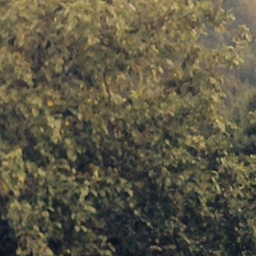

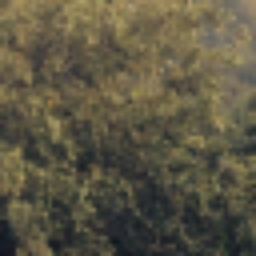

In [37]:
rand_idx = np.random.randint(0, len(ds))
data = ds[rand_idx]
lr, hr = data["lr"], data["hr"]
log_lr = denormalize(lr).type(torch.uint8)
log_hr = denormalize(hr).type(torch.uint8)
log_lr = Resize((256, 256))(log_lr)
display(ToPILImage()(log_hr), ToPILImage()(log_lr))